# The Jacobi Method
**Author**: Théau Blanchard

*Date* : 12/2022

Several implementation of the Jacobi method for solving linear systems in numpy and pytorch. More information about the Jacobi method can be found in the [wikipedia article](https://en.wikipedia.org/wiki/Jacobi_method).

We showcase that this method is a very effective method for solving linear systems quickly. It is possible to increase precision with a moderate cost in time. 

The most important part of this notebook is the implementation of the Jacobi method for sparse matrices in pytorch. For adjency or laplacian matrices, this method demonstrates significant speedup compared to a dense implementation.

In [1]:
import numpy as np
import torch

from torch_geometric.utils import (
    add_self_loops,
    get_laplacian,
    to_dense_adj,
    get_self_loop_attr
)

import timeit
import matplotlib.pyplot as plt

# Numpy implementation

In [2]:
def jacobi_numpy(A, b, K):
    """Solves the equation Ax=b for x using the Jacobi method with K iterations."""
    inv_diag = np.diag(A)**-1
    inv_diag[inv_diag == np.inf] = 0
    off_diag = A - np.diag(np.diag(A))
    J = - np.diag(inv_diag)@off_diag
    b_1 = np.diag(inv_diag)@b
    x_k = b_1.copy()
    for k in range(K):
        x_k = J@x_k + b_1
    return x_k

# Pytorch implementation for dense matrices

In [3]:
def jacobi_dense(A, b, K):
    """Solves the equation Ax=b for x using the Jacobi method with K iterations.
    
    Parameters
    ----------
    A : torch.Tensor, shape (n, n)
    b : torch.Tensor, shape (n,1)
    K : int

    Returns
    -------
    x_k : torch.Tensor, shape (n,), solution estimate of Ax=b
    """
    
    inv_diag = torch.diag(A)**-1
    inv_diag[inv_diag == torch.inf] = 0
    off_diag = A - torch.diag(torch.diag(A))
    J = - torch.diag(inv_diag)@off_diag
    b_1 = torch.diag(inv_diag)@b
    x_k = b_1.clone()
    for k in range(K):
        x_k = J@x_k + b_1
    return x_k

# Pytorch implementation for sparse matrices

In [4]:
def get_diag(edge_index, edge_weight):
    """Computes the diagonal coefficients of the matrix A from the edge_index and edge_weight"""
    mask = (edge_index[0, :] == edge_index[1, :])
    selected_edge_weight = edge_weight[mask]
    unique_edge_index = torch.unique(edge_index[1, :])
    output = torch.zeros_like(unique_edge_index, dtype=edge_weight.dtype)
    output.scatter_add_(0, edge_index[1, mask], selected_edge_weight)
    return output

def jacobi_sparse(edge_index,edge_weight,b,K, num_nodes):
    """Solves the equation Ax=b for x using the Jacobi method with K iterations
    for a square sparse matrix A.
    
    Parameters
    ----------
    edge_index : torch.Tensor, shape (2, n), indices of nonzero entries of A
    edge_weight : torch.Tensor, shape (n,), values of nonzero entries of A
    b : torch.Tensor, shape (n,p)
    K : int, number of iterations to approximate solution
    num_nodes : int, size of the full square matrix A

    Returns
    -------
    x_k : torch.Tensor, shape (n,p), solution estimate of Ax=b
    """
    off_diag_mask = edge_index[0]!=edge_index[1]
    off_diag_index = edge_index[:,off_diag_mask]
    diag_value = get_diag(edge_index,edge_weight)
    diag_index = torch.vstack([torch.arange(num_nodes),torch.arange(num_nodes)])
    inv_diag = diag_value**-1
    inv_diag[inv_diag == torch.inf] = 0

    inv_diag = diag_value**-1
    inv_diag[inv_diag == torch.inf] = 0

    off_diag = edge_weight[off_diag_mask]
    #sparse_coo_tensor to make the dot product Diag^-1 @ OffDiag
    J = - torch.sparse.mm(torch.sparse_coo_tensor(diag_index,inv_diag,(num_nodes,num_nodes)),torch.sparse_coo_tensor(off_diag_index,off_diag,(num_nodes,num_nodes)))
    b_1 = torch.sparse.mm(torch.sparse_coo_tensor(diag_index,inv_diag,torch.Size([num_nodes,num_nodes])),b)
    x_k = b_1.clone()
    for k in range(K):
        x_k = J@x_k + b_1
    return x_k  
    

# Results

We test the method on a particuliar linear system. Here the objective is to solve the equation (6) of the paper "CayleyNets: Graph Convolutional Neural Networks
with Complex Rational Spectral Filters". 
In particuliar we test the method on the normalized laplacian matrix of the Cora dataset.

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
x, edge_index = data.x, data.edge_index
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
#Get the laplacian
edge_index, norm = get_laplacian(edge_index,normalization= "sym",num_nodes=x.shape[0],dtype=torch.complex64)

zoomed_lap = 1. * norm # h*Delta with h=1    

neg_idx, neg_norm = add_self_loops(edge_index=edge_index,edge_attr=zoomed_lap,fill_value=torch.tensor(-1j))  # h*Delta - i*Id
pos_idx, pos_norm = add_self_loops(edge_index=edge_index,edge_attr=zoomed_lap,fill_value=torch.tensor(1j))  # h*Delta + i*Id         

#Put to dense to test the dense implementation
neg_lap_dense = to_dense_adj(neg_idx,edge_attr=neg_norm)[0]
pos_lap_dense = to_dense_adj(pos_idx,edge_attr=pos_norm)[0]

In [8]:
# Parameters of the problem
num_nodes = x.shape[0]
K = 10 # Jacobi iterations
y0 = x.to(torch.complex64) # Initial propagated signal in eq. (6)
b = torch.sparse_coo_tensor(neg_idx, neg_norm, torch.Size([num_nodes,num_nodes]))@y0 # Corresponds to b_j for j = 1 in eq. (7)

In [9]:
y1_true = torch.inverse(pos_lap_dense)@b # True solution of eq. (6) for j = 1

## Speed performances

In [10]:
%timeit y1_true = torch.inverse(pos_lap_dense)@b # True solution
%timeit y1_sparse = jacobi_sparse(pos_idx,pos_norm,b,K,num_nodes) # Sparse implementation
%timeit y1_dense = jacobi_dense(pos_lap_dense,b,K) # Dense implementation


3.41 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
700 ms ± 46.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.2 s ± 340 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Accuracy results

In [143]:
# Parameters of the problem
num_nodes = x.shape[0]
K = 50 # Jacobi iterations
y0 = x.to(torch.complex64) # Initial propagated signal in eq. (6)
b = torch.sparse_coo_tensor(neg_idx, neg_norm, torch.Size([num_nodes,num_nodes]))@y0 # Corresponds to b_j for j = 1 in eq. (7)

In [144]:
c0 = torch.rand(16,x.shape[1])
c1 = torch.rand(16,x.shape[1],dtype=torch.complex64)

In [145]:
# True filter
Gf = x@c0.T + 2*(y1_true@c1.T).real

In [146]:
# Estimated solution at each iteration
estimate_list = []


off_diag_mask = pos_idx[0]!=pos_idx[1]
off_diag_index = pos_idx[:,off_diag_mask]
diag_value = get_diag(pos_idx,pos_norm)
diag_index = torch.vstack([torch.arange(num_nodes),torch.arange(num_nodes)])
inv_diag = diag_value**-1
inv_diag[inv_diag == torch.inf] = 0

inv_diag = diag_value**-1
inv_diag[inv_diag == torch.inf] = 0

off_diag = pos_norm[off_diag_mask]
#sparse_coo_tensor to make the dot product Diag^-1 @ OffDiag
J = - torch.sparse.mm(torch.sparse_coo_tensor(diag_index,inv_diag,(num_nodes,num_nodes)),torch.sparse_coo_tensor(off_diag_index,off_diag,(num_nodes,num_nodes)))
b_1 = torch.sparse.mm(torch.sparse_coo_tensor(diag_index,inv_diag,torch.Size([num_nodes,num_nodes])),b)
y_k = b_1.clone()
estimate_list.append(y_k)
for k in range(K):
    y_k = J@y_k + b_1
    estimate_list.append(y_k)


In [147]:
Gf_k_list = []
for k, y_k in enumerate(estimate_list):
    Gf_k = x@c0.T + 2 * (y_k@c1.T).real
    Gf_k_list.append(Gf_k)

In [148]:
residual = []
norm_f = torch.linalg.norm(x,ord=2)
for k, Gf_k in enumerate(Gf_k_list):
    residual.append(torch.linalg.norm(Gf-Gf_k,ord='fro')/norm_f)


In [149]:
# Compute bound parameters
M = np.sqrt(num_nodes)* c1.abs().sum()
kappa = torch.linalg.norm(J.to_dense(),ord=2)#float('inf'))
print(kappa)

tensor(0.7071)


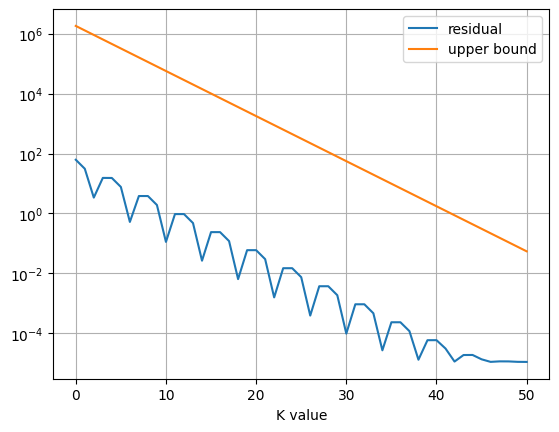

In [154]:
plt.semilogy(residual,label='residual')
plt.semilogy([2*M*kappa**k for k in range(len(residual))],label='upper bound')
plt.xlabel("K value")
plt.legend()
plt.grid()
# plt.savefig("convergence_jacobi.svg")
plt.show()